In [9]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [28]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')
nck_wll.head()

,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [17]:
# Earlier test overlapping with UCB period, and using ESA
# data
if 0:
    #model00=pesca_base.PescaButano.load("run_tide_test")
    model01=pesca_base.PescaButano.load('run_tide_test-v01')
    #model02=pesca_base.PescaButano.load('run_tide_test-v02')
    #model03=pesca_base.PescaButano.load('run_tide_test-v03')
    #model04=pesca_base.PescaButano.load('run_tide_test-v04')
    #model05=pesca_base.PescaButano.load('run_tide_test-v05')
    model06=pesca_base.PescaButano.load('run_tide_test-v06')
    observed=esa_waterlevel['waterlevel'].assign_coords(label="CTD")


In [36]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    model07=pesca_base.PescaButano.load('run_salt_20160520-v00')

In [46]:
bcs=model07.load_bcs()

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [49]:
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]
ocean_bc

{'QUANTITY': 'waterlevelbnd',
 'FILENAME': 'ocean_bc.pli',
 'FILETYPE': '9',
 'METHOD': '3',
 'OPERAND': 'O',
 'name': 'ocean_bc',
 'pli': [('ocean_bc',
   array([[ 552081.42284061, 4124663.59300452],
          [ 552127.64909061, 4124668.95855139]]),
   ['', ''])],
 'coordinates': array([[ 552081.42284061, 4124663.59300452],
        [ 552127.64909061, 4124668.95855139]]),
 'geom': <shapely.geometry.linestring.LineString at 0x7fa317da7640>,
 'data': <xarray.Dataset>
 Dimensions:  (node: 1, time: 7443)
 Coordinates:
   * time     (time) datetime64[ns] 2016-05-19T23:54:00 ... 2016-06-20T00:06:00
 Dimensions without coordinates: node
 Data variables:
     stage    (node, time) float64 0.715 0.717 0.74 0.8 ... 0.865 0.875 0.894
     x        (node) float64 5.521e+05
     y        (node) float64 4.125e+06
 Attributes:
     source:   run_salt_20160520-v00/ocean_bc_0001.tim,
 'bc': <stompy.model.hydro_model.StageBC at 0x7fa318edbdf0>}

In [ ]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

<IPython.core.display.Javascript object>


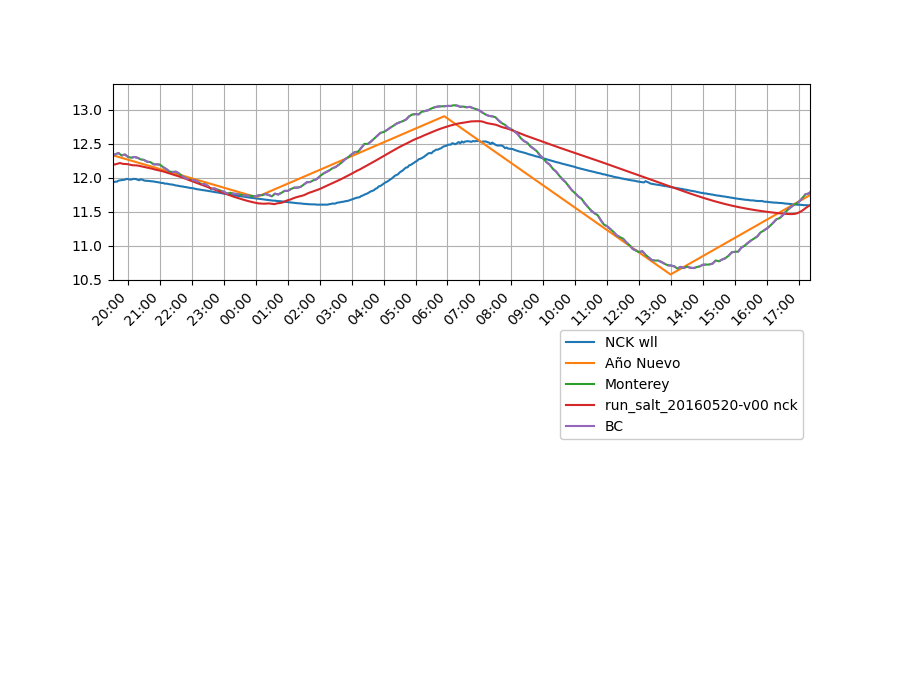

In [94]:
import six
six.moves.reload_module(dc)

sources=[observed]

sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

for model in [model07]:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

# sources[1]['label']=(),'Open mouth, no constriction'
# sources[2]['label']=(),'Open mouth, partial constriction'
fig=dc.calibration_figure_3panel(sources,trim_time=True,lowpass=False,metric_x=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207, 
                  10.497886219416628, 13.38061368842699])

from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[4].set_linestyle('--')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)

In [95]:
fig.savefig('manytides.png',dpi=200)

In [104]:
sources[3]

<xarray.DataArray 'waterlevel' (time: 8929)>
array([0.717   , 0.718148, 0.732951, ..., 0.856075, 0.867073, 0.877128])
Coordinates:
    station_x_coordinate  float64 ...
    station_y_coordinate  float64 ...
    station_name          |S64 b'nck'
  * time                  (time) datetime64[ns] 2016-05-20 ... 2016-06-20
    label                 <U25 'run_salt_20160520-v00 nck'
Attributes:
    standard_name:  sea_surface_height
    long_name:      water level
    units:          m
    geometry:       station_geom

In [39]:
# And what about the timing of ocean tides compared to the model and observed inside
# the lagoon?

his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 4, nFlowElemContourPts: 4, nFlowElemWithBnd: 5366, nFlowLink: 8392, nFlowLinkPts: 2, nNetLink: 8627, nNetLinkPts: 2, station_geom_nNodes: 15, stations: 15, time: 8929)
Coordinates:
    station_x_coordinate                     (stations) float64 ...
    station_y_coordinate                     (stations) float64 ...
    station_name                             (stations) |S64 b'pch_up' ... b'...
    cross_section_name                       (cross_section) |S64 ...
    gategen_name                             (gategens) |S64 ...
  * time                                     (time) datetime64[ns] 2016-05-20...
Dimensions without coordinates: cross_section, gategens, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 ...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 ...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 ...
    FlowElem_bac                             (nFlowElemWithBnd) float64 ...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 ...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 ...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 ...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 ...
    FlowLink_xu                              (nFlowLink) float64 ...
    FlowLink_yu                              (nFlowLink) float64 ...
    projected_coordinate_system              int32 ...
    FlowLink_lonu                            (nFlowLink) float64 ...
    FlowLink_latu                            (nFlowLink) float64 ...
    FlowElemDomain                           (nFlowElemWithBnd) int32 ...
    FlowLinkDomain                           (nFlowLink) int32 ...
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 ...
    station_id                               (stations) |S64 ...
    station_geom                             int32 ...
    station_geom_node_count                  (stations) int32 ...
    station_geom_node_coordx                 (station_geom_nNodes) float64 ...
    station_geom_node_coordy                 (station_geom_nNodes) float64 ...
    waterlevel                               (time, stations) float64 ...
    bedlevel                                 (stations) float64 ...
    x_velocity                               (time, stations) float64 ...
    y_velocity                               (time, stations) float64 ...
    salinity                                 (time, stations) float64 ...
    taus                                     (time, stations) float64 ...
    temperature                              (time, stations) float64 ...
    density                                  (time, stations) float64 ...
    cross_section_geom                       int32 ...
    cross_section_geom_node_count            (cross_section) int32 ...
    cross_section_discharge                  (time, cross_section) float64 ...
    cross_section_cumulative_discharge       (time, cross_section) float64 ...
    cross_section_area                       (time, cross_section) float64 ...
    cross_section_velocity                   (time, cross_section) float64 ...
    cross_section_cumulative_salt            (time, cross_section) float64 ...
    cross_section_salt                       (time, cross_section) float64 ...
    cross_section_cumulative_temperature     (time, cross_section) float64 

In [ ]:
## 
plt.figure(1).clf()
fig,ax=plt.subplots(num=1)
ax.plot(predicted.time,predicted,label='Model')

sel=slice(*np.searchsorted( esa_waterlevel.time.values,
                            [predicted.time.values[0], predicted.time.values[-1]] ))

esa_select=esa_waterlevel.waterlevel.isel(time=sel)
ax.plot(esa_select.time-np.timedelta64(3600,'s'),
        esa_select,label='ESA compiled\nobservations')
ax.legend(loc='upper right')

ax.set_ylabel('water level (m NAVD88)')

##
plt.figure(2).clf()
plt.plot( esa_waterlevel.time, esa_waterlevel.waterlevel)

plt.show()